# Simple 3D Finite Plasticity model



In [ ]:
import numpy as np

import dolfinx

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot, log,default_scalar_type
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem,LinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import XDMFFile, VTXWriter
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional , gt, dx, inner, derivative, dot, ln, split,TestFunction,indices,as_tensor)
from basix.ufl import element, mixed_element, quadrature_element
from datetime import datetime
from dolfinx.plot import vtk_mesh
from dolfinx.fem.petsc import  assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc,create_matrix, create_vector
import basix
import pyvista
pyvista.set_jupyter_backend('client')
## Define temporal parameters

## Some parameters

In [ ]:
problem_name = "Plastic Tensile Test"
# Geometric parameters
geom = {"longside" : 100.0,     # mm
        "side" : 10.0,      # mm
        "num_elements" : 3,    # size of a cell
        }


# Mechanicals parameters
mech = {"E" : 200e3,    # MPa
        "nu" : 0.3,     #       
        "sig0" : 100.,  # MPa
        "H" : 80e3, # MPa
        "r" : 2.0,
        "Y_s" : 250.0 #mpa
        
        }


# Study parameters
stud = {"deg u" : 2,    # Interpolation of u
        "deg sig" : 2,  # Interpolation of sig, eps, p
        "N incr" : 100,  # Number of load steps
        "Max Disp" : 1 # Maximal displacement
        }


# Define Geometry

In [ ]:
domain = mesh.create_box(MPI.COMM_WORLD,[[0.0,0.0,0.0],[geom["longside"],geom["side"],geom["side"]]],[geom["num_elements"]*10,geom["num_elements"],geom["num_elements"]])

In [ ]:
plotter = pyvista.Plotter()
vtkdata = vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(*vtkdata)
actor = plotter.add_mesh(grid, show_edges=True)
plotter.show()
plotter.close()

Widget(value="<iframe src='http://localhost:34107/index.html?ui=P_0xffff6c381720_0&reconnect=auto' style='widt…

## Material Parameters

In [ ]:
E = Constant(domain, mech["E"])
nu = Constant(domain, mech["nu"])
lmbda = E * nu / (1 + nu) / (1 - 2 * nu)
mu = E / 2.0 / (1 + nu)
sig0 = Constant(domain, mech["sig0"])  # yield strength
H_0 = Constant(domain,mech["H"])  # hardening modulus
r = Constant(domain,mech["r"])  # hardening modulus
Y_s = Constant(domain,mech["Y_s"])  # hardening modulus

## Defining Boundary

In [ ]:
def xBot(x):
    return np.isclose(x[0], 0)
def xTop(x):
    return np.isclose(x[0], geom["longside"])
def yBot(x):
    return np.isclose(x[1], 0)
def yTop(x):
    return np.isclose(x[1], geom["side"])
def zBot(x):
    return np.isclose(x[2], 0)
def zTop(x):
    return np.isclose(x[2], geom["side"])

In [ ]:
boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,zTop)]

facet_indices, facet_markers = [], []
fdim = domain.topology.dim - 1
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])


# Defining Function Spaces

In [ ]:
deg_u = stud["deg u"]
deg_stress = stud["deg sig"]
Ve = element(
    "Lagrange", domain.basix_cell(), deg_u, shape=(3,)
)  # 2 degrees  of freedom
V = functionspace(domain, Ve)

Ve_scal = element(
    "Lagrange", domain.basix_cell(), deg_u
)
V_scal = functionspace(domain, Ve_scal)

We = quadrature_element(domain.basix_cell(), value_shape=(6,), degree=deg_stress,scheme='default')
W = functionspace(domain, We)
test = None
W_scal_e = quadrature_element(domain.basix_cell(), degree=deg_stress,scheme='default')
W_scal = functionspace(domain, W_scal_e)

In [ ]:
E_p = Function(W, name="Total_Plastic_Strain")
e_p= Function(W_scal, name="Equivalent_Plastic_Strain")
u = Function(V, name="Total_displacement")
du = Function(V, name="Trial_displacement")

dp = Function(W_scal,name="Delta_plasticity")

Y = Function(W_scal,name="Isotropic_Hardening")
A = Function(W_scal,name="Kinematic_Hardening")

Y.interpolate(lambda x: np.full_like(x[0],mech["sig0"]))
test = None

v = TestFunction(V) #Function we are testing with
du_ = TrialFunction(V) #Function we are solving for

e_p_ = TrialFunction(W_scal)
e_pv = TestFunction(W_scal)


dx = ufl.Measure("dx",domain=domain,  metadata={"quadrature_degree": deg_u, "quadrature_scheme": "default"} )
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tag,metadata={'quadrature_degree': deg_u})

n = ufl.FacetNormal(domain)

# Boundary Conditions

In [ ]:
left_facets = facet_tag.find(1)
right_facets = facet_tag.find(2)
fdim = domain.topology.dim - 1
domain.topology.create_connectivity(fdim, domain.topology.dim)
disp = Constant(domain,0.0)

left_dofs_x = fem.locate_dofs_topological(V, fdim, left_facets)
right_dofs_x = fem.locate_dofs_topological(V.sub(0),fdim, right_facets)

sym_bottom = fem.dirichletbc(np.array((0.0,0.0,0.0)), left_dofs_x, V)
sym_left = fem.dirichletbc(disp, right_dofs_x, V.sub(0))

bcs = [sym_bottom, sym_left]



def F_ext(t):
    return t*stud["Max Disp"]

# Constitive Relations

In [ ]:
from ufl.tensors import ComponentTensor


def eps(v: Function) -> ComponentTensor:
    """
    Generates a  strain tensor from input of a 3D displacement vector.


    Parameters:
    -----------
        u (2d Vector Funciton): 3D displacement vector.

    Returns:
    --------
        3x3 Tensor: Plain strain tensor generated from the displacement vector.
    """
    e = ufl.sym(grad(v))
    return e # Plain strain tensor


def as_3D_tensor(X):
    """Converts an array to a 3D tensor.

    Parameters:
    ----------
       X (Function): Array to be converted to 3D tensor.

    Returns:
    --------
        3x3 Tensor: 3D tensor generated from the input array.
    """
    return ufl.as_tensor([[X[0], X[3], X[4]],
                      [X[3], X[1], X[5]],
                      [X[4], X[5], X[2]]])

def tensor_to_vector(X): 
    ''' 
    Take a 3x3 tensor and return a vector of size 4 in 2D
    '''
    return ufl.as_vector([X[0, 0], X[1, 1], X[2, 2], X[0, 1], X[0, 2], X[1, 2]])


def sigma(eps_el: Function) -> ComponentTensor:
    
    return lmbda * tr(eps_el) * Identity(3) + 2 * mu * eps_el


In [ ]:
def normVM(sig): # Von Mises equivalent stress
    s_ = ufl.dev(sig)
    return ufl.sqrt(3 / 2. * ufl.inner(s_, s_))

In [ ]:
#This is the plastic stress function (For now we'll just assume regular strain hardening)


def Y_dot(e_p):
    
    H_val = H_0*(1-Y/Y_s)**r
    return H_val * e_p

In [ ]:
E_n = eps(u)
del_E_n = eps(du_)
E_p_tensor = as_3D_tensor(E_p)
E_e_trial = E_n - E_p_tensor + del_E_n #Trial Elastic Strain

T_trial = sigma(E_e_trial) #Trial cauchy stress
#bilinear Part to solve for du Incrementally
#This is the linear part (In total this will be 0)
F_body = Constant(domain,np.array((0.0,0.0,0.0)))

F = ufl.inner(T_trial,eps(v))*dx - ufl.inner(F_body, v) * dx 

a_du, L_du = ufl.lhs(F), ufl.rhs(F)

In [ ]:

del_E = eps(du)
E_e_trial_plastic = E_n - E_p_tensor + del_E #Trial Elastic Strain for plastic step
T_trial_p = sigma(E_e_trial_plastic)

sigma_vm_trial = normVM(T_trial_p) #Trial Von Mises Stress

N_p = dev(T_trial_p)/sigma_vm_trial

f_trial = sigma_vm_trial - Y #Trial Yield Function


Phi = sigma_vm_trial - 3*mu*dp - Y - Y_dot(dp)
Phi_cond = conditional(gt(f_trial, 0) , Phi, dp) #Plastic multiplier

res_p = inner(Phi_cond,e_pv)*dx


Jacobian = derivative(res_p,dp,e_p_)

In [ ]:

problem = NonlinearProblem(res_p, dp, [], Jacobian)
nls_solver = NewtonSolver(MPI.COMM_WORLD, problem)
#nls_solver.convergence_criterion = "incremental"
nls_solver.rtol = 1e-8
nls_solver.atol = 1e-8
nls_solver.max_it = 50
nls_solver.report = True
nls_solver.relaxation_parameter = 1



ksp = nls_solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
#opts[f"{option_prefix}pc_hypre_type"] = "boomeramg"
#opts[f"{option_prefix}pc_factor_mat_solver_type"] = "superlu_dist"
opts[f"{option_prefix}ksp_max_it"] = 50
ksp.setFromOptions()

In [ ]:
def project(v, target_func, bcs=[]):
    """Project UFL expression.

    Note
    ----
    This method solves a linear system (using KSP defaults).

    """

    # Ensure we have a mesh and attach to measure
    V = target_func.function_space
    dx = ufl.dx(V.mesh)

    # Define variational problem for projection
    w = ufl.TestFunction(V)
    Pv = ufl.TrialFunction(V)
    a = dolfinx.fem.form(ufl.inner(Pv, w) * dx)
    L = dolfinx.fem.form(ufl.inner(v, w) * dx)

    # Assemble linear system
    A = assemble_matrix(a, bcs)
    A.assemble()
    b = assemble_vector(L)
    apply_lifting(b, [a], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, bcs)

    # Solve linear system
    solver = PETSc.KSP().create(A.getComm())
    solver.setOperators(A)
    solver.solve(b, target_func.vector)

    # Destroy PETSc linear algebra objects and solver
    solver.destroy()
    A.destroy()
    b.destroy()

In [ ]:
def solve_plastic():
    # Solve DP

    nls_solver.solve(dp)
    # Do updates
    e_p_exp = Expression(e_p+dp,W_scal.element.interpolation_points())
    e_p.interpolate(e_p_exp)
    
    E_p_expr = Expression(E_p+tensor_to_vector(N_p*dp*sqrt(3/2)),W.element.interpolation_points())
    
    E_p.interpolate(E_p_expr)
    
    Y_exp = Expression(Y + Y_dot(dp),W_scal.element.interpolation_points())
    Y.interpolate(Y_exp)

In [ ]:

a = fem.form(a_du)
L = fem.form(L_du)
A = assemble_matrix(a, bcs=bcs)
A.assemble()
b = create_vector(L)
assemble_vector(b, L)
apply_lifting(b, [a], [bcs],[u.vector], scale=1)
set_bc(b, bcs,u.vector)


Stress_Point = sigma(E_n - E_p_tensor)
area= Constant(domain,(geom["side"]*geom["side"]))

Elastic = Function(V_scal)
project(Stress_Point[0,0],Elastic)
engineeringStress= fem.form(Elastic/area*ds(2)) #P22/area*ds

In [ ]:
pointForStress = [geom["longside"],0,0]

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, np.array(pointForStress))
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates,  np.array(pointForStress))

In [ ]:
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

def solve_linear():
    with b.localForm() as loc_L:
            loc_L.set(0)
    A.zeroEntries()
    assemble_matrix(A,a, bcs=bcs)
    A.assemble()
    assemble_vector(b, L)
    
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    apply_lifting(b, [a], [bcs],[ u.vector], scale=1)

    set_bc(b, bcs,u.vector)
    
    solver.solve(b, du.vector)



# Interpolation And Visualization

In [ ]:
# We need to create a few visualization functions

UV = element("Lagrange", domain.basix_cell(), 1,shape =(3,))
UT = element("Lagrange", domain.basix_cell(), 1,shape =(3,3),symmetry=True)
U1 = element("Lagrange", domain.basix_cell(), 1)

VV = fem.functionspace(domain, UV)  # Vector function space
VT = fem.functionspace(domain, UT)  # Vector function space
V1 = fem.functionspace(domain, U1)  # Scalar function space


u_vis = Function(VV,name="Displacement")
u_expr = Expression(u, VV.element.interpolation_points())


T_vis = Function(VT,name="Stress")
T_expr = Expression(T_trial_p,VT.element.interpolation_points())

E_vis = Function(VT,name="Strain")
E_expr = Expression(E_n,VT.element.interpolation_points())

Y_vis = Function(V1,name="Yield")
Y_expr = Expression(Y,V1.element.interpolation_points())

E_p_vis = Function(VT,name="Plastic_Strain")
E_p_expr = Expression(E_p_tensor,VT.element.interpolation_points())

e_p_vis = Function(V1,name="Equivalent_Plastic_Strain")
e_p_expr = Expression(e_p,V1.element.interpolation_points())

Mises_vis = Function(V1,name="Mises")
Mises_expr = Expression(normVM(T_trial_p),V1.element.interpolation_points())

vtk = VTXWriter(
    domain.comm,
    "results/" + problem_name + ".bp",
    [u_vis, T_vis, E_vis, Y_vis,E_p_vis,e_p_vis,Mises_vis],
    engine="BP4",
)


def update_and_save(t):
    u_vis.interpolate(u_expr)
    T_vis.interpolate(T_expr)
    E_vis.interpolate(E_expr)
    Y_vis.interpolate(Y_expr)
    E_p_vis.interpolate(E_p_expr)
    e_p_vis.interpolate(e_p_expr)
    Mises_vis.interpolate(Mises_expr)
    vtk.write(t)
    

#phi_expr = Expression(DE_prob.phi, V1.element.interpolation_points())


#T = DE_prob.Tmat * DE_prob.F.T / DE_prob.J  # Cauchy Stress

#T0 = T - (1 / 3) * tr(T) * Identity(3)
#Mises = sqrt((3 / 2) * inner(T0, T0))


In [ ]:
startTime = datetime.now()
Nincr = stud["N incr"]

load_steps = np.linspace(0, 1, Nincr+1)[1:]
results = np.zeros((Nincr+1, 2))


print("------------------------------------")
print("Simulation Start")
print("------------------------------------")


#log.set_log_level(log.LogLevel.INFO)
update_and_save(0)
for (i, t) in enumerate(load_steps):
    # Update Diriclet boundary condition
   
    disp.value = F_ext(t)
    # Update the right hand side reusing the initial vector

    nRes0 = b.norm()
    nRes = nRes0
    print("Increment:", str(i+1))
    niter = 0
    print("Linear Step 1 Start")
    solve_linear() #Solves for the first trial displacement
    print("Linear Step 1 Done")
    print("Starting Plastic Step")
    solve_plastic()
    print("Stop Plastic Step  Done")
    print("Linear Step 2 Start")
    solve_linear() #Solves for the actual displacement after the plastic update
    print("Linear Step 1 Done")
    
    
    u.x.array[:] += du.x.array[:]
    du.x.array[:] = 0.0
    dp.x.array[:] = 0.0
    
    
    
    project(Stress_Point[0,0],Elastic)
    u_pointe = u.eval(pointForStress,colliding_cells.array[0])[0]
    stress =  domain.comm.gather(fem.assemble_scalar(engineeringStress))[0]
    results[i + 1, :] = (u_pointe,stress)
    
    update_and_save(t)
    

print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")    
vtk.close()

------------------------------------
Simulation Start
------------------------------------
Increment: 1
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 2
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 3
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 4
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 5
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 6
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 7
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic 

In [ ]:
Plastic_Strain = Function(V_scal)

project(e_p,Plastic_Strain)

In [ ]:
plotter = pyvista.Plotter()
topology, cells, geometry = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cells, geometry)


values = np.zeros((geometry.shape[0], 3))

values[:, :len(u)] = u.x.array.reshape(geometry.shape[0], len(u))
grid["u"]=values

warp = grid.warp_by_vector("u", factor=100)
warp["Plastic Strain"]=Plastic_Strain.x.array
warp.set_active_scalars("Plastic Strain")
actor = plotter.add_mesh(warp, show_edges=True)

plotter.show()
plotter.close()

Widget(value="<iframe src='http://localhost:34107/index.html?ui=P_0xffff6c0f6650_0&reconnect=auto' style='widt…

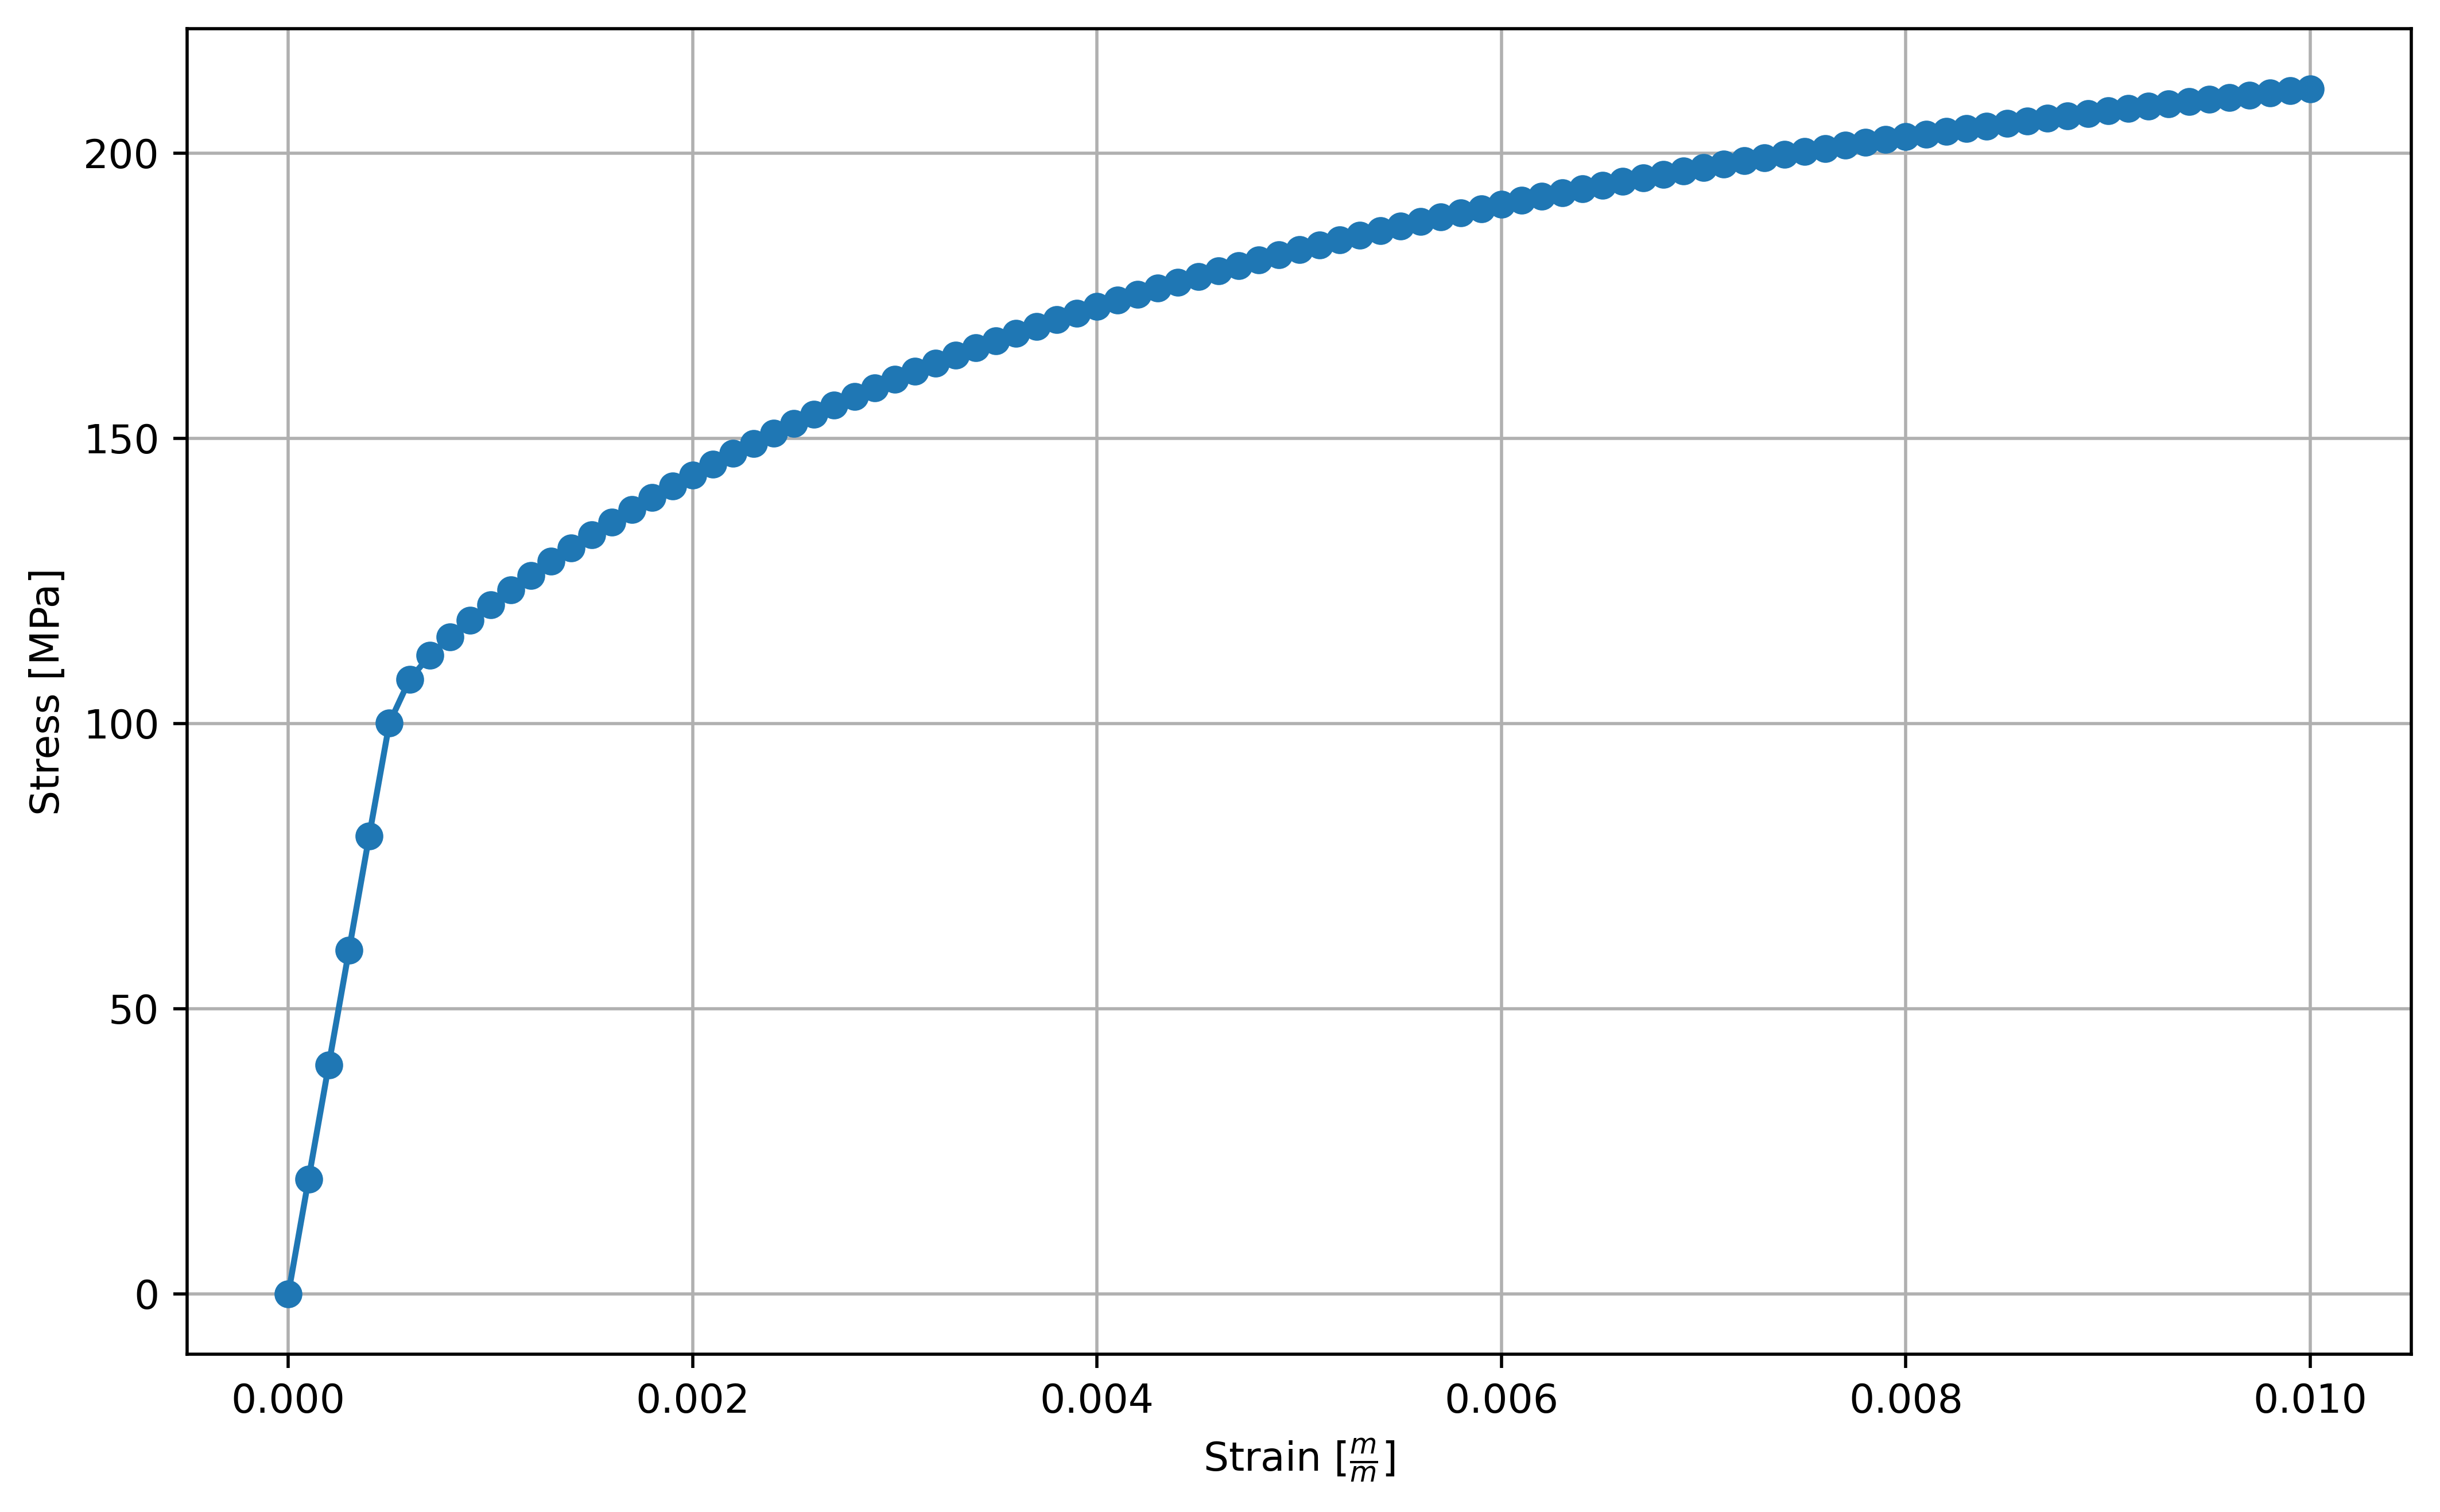

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6),dpi=500)
plt.plot(results[:, 0]/geom["longside"], results[:, 1], "-o")
plt.xlabel(r"Strain [$\frac{m}{m}$]")
plt.ylabel(r"Stress [MPa]")
plt.grid()
plt.show()